In [3]:
import pandas as pd
pd.options.display.float_format = '{:.6g}'.format
import scipy.cluster.hierarchy
import scipy.spatial.distance
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import warnings
warnings.filterwarnings('ignore')
from hrp import HRP
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time

# OOS PERFORMANCE

In [4]:
def get_oos_ret_freq(data,start_date,end_date,freq="M"):
    """
    Get Out of Sample data in returns format for each frequency period.
    """
    filter_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    filter_data.set_index('Date', inplace=True)
    returns_df = filter_data.pct_change().dropna(how="all").dropna(axis=1, how="all").fillna(0)
    adj_ret = returns_df + 1
    adj_ret_freq = adj_ret.groupby(adj_ret.index.to_period(freq)).cumprod()
    ret_freq = adj_ret_freq.resample(freq).last().fillna(0)
    ret_freq[['EQ_Ret','HRP_Ret','RP_Ret','MV_Ret']] = 0

    return ret_freq

def get_rolling_returns(main_data, data_oos, lookback_days):
    """
    Get Rolling returns with training only given lookback_days.
    Also, Get variance of weights
    """
    start_timer = time.time()

    #WEIGHTS dataframes
    HRP_WEIGHT = data_oos.copy()
    RP_WEIGHT = data_oos.copy()
    MV_WEIGHT = data_oos.copy()
    
    # weights_df = data_oos.copy()
    # weights_df[['EQ_Ret','HRP_Ret','RP_Ret','MV_Ret']] = 0
    # weights_df['EQ_Ret'] = 1/data_oos.shape[1]
    
    num_assets = data_oos.shape[1] - 4
    eq_weights = 1/num_assets
    data_oos['EQ_Ret'] = np.sum(data_oos.iloc[:,:num_assets] * eq_weights, axis=1)

    for i, date in enumerate(data_oos.index):
        end_date_train = (date.replace(day=1) - timedelta(days=1))
        start_date_train = end_date_train - relativedelta(days=lookback_days)

        end_date_train = end_date_train.strftime("%Y-%m-%d")
        start_date_train = start_date_train.strftime("%Y-%m-%d")

        if (i+1)%5==0 or (i==0):
            print(f"Starting train iteration {i+1}. Start: {start_date_train}. End: {end_date_train}")

        hrp_oos = HRP(prior_data=main_data, start_date=start_date_train, end_date=end_date_train)

        hrp_weights = pd.Series(hrp_oos.calculate_hrp_weights())
        rp_weights = pd.Series(hrp_oos.calculate_RP_weights())
        mv_weights = pd.Series(hrp_oos.calculate_MV_weights())

        # HRP_WEIGHT = pd.concat([HRP_WEIGHT, hrp_weights], axis=1)
        # RP_WEIGHT = pd.concat([RP_WEIGHT, rp_weights], axis=1)
        # MV_WEIGHT = pd.concat([MV_WEIGHT, mv_weights], axis=1)
        HRP_WEIGHT.loc[date] = hrp_weights
        RP_WEIGHT.loc[date] = rp_weights
        MV_WEIGHT.loc[date] = mv_weights
        
        data_oos.loc[date,'HRP_Ret'] = np.sum(data_oos.iloc[i,:num_assets] * hrp_weights)
        data_oos.loc[date,'RP_Ret'] = np.sum(data_oos.iloc[i,:num_assets] * rp_weights)
        data_oos.loc[date,'MV_Ret'] = np.sum(data_oos.iloc[i,:num_assets] * mv_weights)
        
    HRP_WEIGHT.dropna(inplace=True, axis=1)
    RP_WEIGHT.dropna(inplace=True, axis=1)
    MV_WEIGHT.dropna(inplace=True, axis=1)
    
    HRP_WEIGHT_VAR = np.mean(HRP_WEIGHT.T.var())
    RP_WEIGHT_VAR = np.mean(RP_WEIGHT.T.var())
    MV_WEIGHT_VAR = np.mean(MV_WEIGHT.T.var())

    weight_var_df = pd.DataFrame({
        'HRP': HRP_WEIGHT_VAR,
        'RP': RP_WEIGHT_VAR,
        'MV': MV_WEIGHT_VAR
    },index=["Variance"]).T


    end_timer = time.time()
    print(f"Time Taken for training: {end_timer-start_timer:.4f} sec")
    
    return data_oos[['EQ_Ret','HRP_Ret','RP_Ret','MV_Ret']], weight_var_df, {'hrp': HRP_WEIGHT, 'rp': RP_WEIGHT, 'mv': MV_WEIGHT}

def get_ret_stats(roll_df):
    """
    Get Mean and Variance of stats, IN PERCENTAGE
    """
    stats_df = pd.DataFrame({
        'Mean': (roll_df.mean() - 1) * 12,
        'Standard Deviation': roll_df.std()
    }).T
    return stats_df


In [5]:
legend_names = ['Uniform', 'HRP', 'Inverse Variance', 'Minimum Variance']

### EQUITIES

In [6]:
stock_data = pd.read_csv('data/sp500v2.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

start_stock_oos = '2018-01-01'
end_stock_oos= '2024-12-31'

oos_stock_data = get_oos_ret_freq(stock_data, start_stock_oos, end_stock_oos,"M")
rolling_returns_stock, weight_var_stock, weights_dict_stock = get_rolling_returns(stock_data, oos_stock_data, 2*365)
equity_stats = get_ret_stats(rolling_returns_stock)

Starting train iteration 1. Start: 2016-01-01. End: 2017-12-31
Starting train iteration 5. Start: 2016-04-30. End: 2018-04-30
Starting train iteration 10. Start: 2016-09-30. End: 2018-09-30
Starting train iteration 15. Start: 2017-02-28. End: 2019-02-28
Starting train iteration 20. Start: 2017-07-31. End: 2019-07-31
Starting train iteration 25. Start: 2017-12-31. End: 2019-12-31
Starting train iteration 30. Start: 2018-06-01. End: 2020-05-31
Starting train iteration 35. Start: 2018-11-01. End: 2020-10-31
Starting train iteration 40. Start: 2019-04-01. End: 2021-03-31
Starting train iteration 45. Start: 2019-09-01. End: 2021-08-31
Starting train iteration 50. Start: 2020-02-01. End: 2022-01-31
Starting train iteration 55. Start: 2020-06-30. End: 2022-06-30
Starting train iteration 60. Start: 2020-11-30. End: 2022-11-30
Starting train iteration 65. Start: 2021-04-30. End: 2023-04-30
Starting train iteration 70. Start: 2021-09-30. End: 2023-09-30
Starting train iteration 75. Start: 2022-0

In [7]:
print(len(rolling_returns_stock))
rolling_returns_stock.head(5)

84


,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.04098,1.03431,1.03594,0.868047
2018-02-28,0.962922,0.958622,0.958894,0.845916
2018-03-31,0.997609,0.997788,0.99792,1.03545
2018-04-30,1.00145,1.00419,0.999729,1.14137
2018-05-31,1.02392,1.04262,1.02308,1.09327


In [8]:
rolling_returns_stock

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.04098,1.03431,1.03594,0.868047
2018-02-28,0.962922,0.958622,0.958894,0.845916
2018-03-31,0.997609,0.997788,0.99792,1.03545
2018-04-30,1.00145,1.00419,0.999729,1.14137
2018-05-31,1.02392,1.04262,1.02308,1.09327
...,...,...,...,...
2024-08-31,1.02632,1.04172,1.03666,0.963564
2024-09-30,1.02361,1.02068,1.01983,1.00662
2024-10-31,0.984908,0.986198,0.985219,0.931611


In [9]:
weight_var_stock

,Variance
HRP,1.7542e-06
RP,9.7391e-07
MV,0.0296774


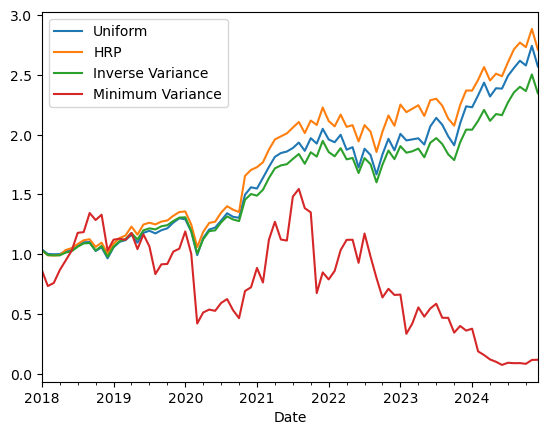

In [10]:
rolling_returns_stock.cumprod().plot()
plt.legend(labels=legend_names)
plt.show()

### COMMODITIES

In [11]:
comm_data = pd.read_csv('data/commodities_data.csv')
comm_data['Date'] = pd.to_datetime(comm_data['Date'])

start_comm_oos = '2018-01-01'
end_comm_oos= '2024-12-31'

oos_comm_data = get_oos_ret_freq(comm_data,start_comm_oos,end_comm_oos,"M")
rolling_returns_comm, weight_var_comm, weights_dict_comm = get_rolling_returns(comm_data, oos_comm_data, 2*365)
comm_stats = get_ret_stats(rolling_returns_comm)

Starting train iteration 1. Start: 2016-01-01. End: 2017-12-31
Starting train iteration 5. Start: 2016-04-30. End: 2018-04-30
Starting train iteration 10. Start: 2016-09-30. End: 2018-09-30
Starting train iteration 15. Start: 2017-02-28. End: 2019-02-28
Starting train iteration 20. Start: 2017-07-31. End: 2019-07-31
Starting train iteration 25. Start: 2017-12-31. End: 2019-12-31
Starting train iteration 30. Start: 2018-06-01. End: 2020-05-31
Starting train iteration 35. Start: 2018-11-01. End: 2020-10-31
Starting train iteration 40. Start: 2019-04-01. End: 2021-03-31
Starting train iteration 45. Start: 2019-09-01. End: 2021-08-31
Starting train iteration 50. Start: 2020-02-01. End: 2022-01-31
Starting train iteration 55. Start: 2020-06-30. End: 2022-06-30
Starting train iteration 60. Start: 2020-11-30. End: 2022-11-30
Starting train iteration 65. Start: 2021-04-30. End: 2023-04-30
Starting train iteration 70. Start: 2021-09-30. End: 2023-09-30
Starting train iteration 75. Start: 2022-0

In [12]:
weights_dict_comm['rp'].head(5)

,Gold,Silver,Crude Oil,Natural Gas,Copper,Corn,Wheat,Soybeans,Gasoline
Date,,,,,,,,,
2018-01-31,0.30027,0.10736,0.03856,0.02862,0.14816,0.11474,0.07899,0.15291,0.03039
2018-02-28,0.3016,0.10787,0.04498,0.02737,0.14678,0.11303,0.07678,0.15046,0.03113
2018-03-31,0.32355,0.10614,0.05096,0.02694,0.13809,0.10778,0.071,0.14231,0.03323
2018-04-30,0.32729,0.10893,0.05349,0.02686,0.13778,0.10444,0.06701,0.13445,0.03975
2018-05-31,0.32836,0.10798,0.05607,0.02786,0.13505,0.10471,0.06512,0.13523,0.03962


In [13]:
rolling_returns_comm.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.02714,1.0173,1.02026,1.01942
2018-02-28,0.981045,0.992735,0.995146,1.00195
2018-03-31,1.01813,1.00346,1.00439,1.00284
2018-04-30,1.03062,1.01396,1.01549,1.00345
2018-05-31,1.00754,0.997566,0.997695,0.989033


In [14]:
comm_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,0.104574,0.0828134,0.0939712,0.102818
Standard Deviation,0.0498016,0.0367042,0.0363755,0.0298857


In [15]:
weight_var_comm

,Variance
HRP,0.00879453
RP,0.0106302
MV,0.0985554


### INDEXES

In [16]:
ind_data = pd.read_csv('data/daily_index_data_last_5_years.csv')
ind_data['Date'] = pd.to_datetime(ind_data['Date'])

start_ind_oos = '2018-01-01'
end_ind_oos= '2024-12-31'

oos_ind_data = get_oos_ret_freq(ind_data,start_ind_oos,end_ind_oos,"M")
rolling_returns_ind, weight_var_ind, weights_dict_ind = get_rolling_returns(ind_data,oos_ind_data, 2*365)
ind_stats = get_ret_stats(rolling_returns_ind)

Starting train iteration 1. Start: 2016-01-01. End: 2017-12-31
Starting train iteration 5. Start: 2016-04-30. End: 2018-04-30
Starting train iteration 10. Start: 2016-09-30. End: 2018-09-30
Starting train iteration 15. Start: 2017-02-28. End: 2019-02-28
Starting train iteration 20. Start: 2017-07-31. End: 2019-07-31
Starting train iteration 25. Start: 2017-12-31. End: 2019-12-31
Starting train iteration 30. Start: 2018-06-01. End: 2020-05-31
Starting train iteration 35. Start: 2018-11-01. End: 2020-10-31
Starting train iteration 40. Start: 2019-04-01. End: 2021-03-31
Starting train iteration 45. Start: 2019-09-01. End: 2021-08-31
Starting train iteration 50. Start: 2020-02-01. End: 2022-01-31
Starting train iteration 55. Start: 2020-06-30. End: 2022-06-30
Starting train iteration 60. Start: 2020-11-30. End: 2022-11-30
Starting train iteration 65. Start: 2021-04-30. End: 2023-04-30
Starting train iteration 70. Start: 2021-09-30. End: 2023-09-30
Starting train iteration 75. Start: 2022-0

In [17]:
rolling_returns_ind.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.03126,1.03228,1.03654,1.03452
2018-02-28,0.960301,0.962375,0.961957,0.968334
2018-03-31,0.985219,0.983132,0.981763,0.969434
2018-04-30,1.01227,1.01785,1.01273,1.04281
2018-05-31,1.01748,1.01031,1.01658,0.994507


In [18]:
ind_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,0.0981801,0.0766183,0.0881391,0.0319379
Standard Deviation,0.0462969,0.0417255,0.044118,0.0362482


In [19]:
weight_var_ind

,Variance
HRP,0.00202508
RP,0.000585605
MV,1.22966


### CURRENCIES

In [20]:
curr = pd.read_csv('data/usd_exchange_rates.csv')
curr['Date'] = pd.to_datetime(curr['Date'])
curr_data = curr.copy()
curr_data.iloc[:,1:] = curr_data.iloc[:,1:].replace(".",np.nan).apply(pd.to_numeric)

start_curr_oos = '2018-01-01'
end_curr_oos= '2024-12-31'

oos_curr_data = get_oos_ret_freq(curr_data,start_curr_oos,end_curr_oos,"M")
rolling_returns_curr, weight_var_curr, weights_dict_curr = get_rolling_returns(curr_data,oos_curr_data, 2*365)
curr_stats = get_ret_stats(rolling_returns_curr)

Starting train iteration 1. Start: 2016-01-01. End: 2017-12-31
Starting train iteration 5. Start: 2016-04-30. End: 2018-04-30
Starting train iteration 10. Start: 2016-09-30. End: 2018-09-30
Starting train iteration 15. Start: 2017-02-28. End: 2019-02-28
Starting train iteration 20. Start: 2017-07-31. End: 2019-07-31
Starting train iteration 25. Start: 2017-12-31. End: 2019-12-31
Starting train iteration 30. Start: 2018-06-01. End: 2020-05-31
Starting train iteration 35. Start: 2018-11-01. End: 2020-10-31
Starting train iteration 40. Start: 2019-04-01. End: 2021-03-31
Starting train iteration 45. Start: 2019-09-01. End: 2021-08-31
Starting train iteration 50. Start: 2020-02-01. End: 2022-01-31
Starting train iteration 55. Start: 2020-06-30. End: 2022-06-30
Starting train iteration 60. Start: 2020-11-30. End: 2022-11-30
Starting train iteration 65. Start: 2021-04-30. End: 2023-04-30
Starting train iteration 70. Start: 2021-09-30. End: 2023-09-30
Starting train iteration 75. Start: 2022-0

In [21]:
rolling_returns_comm.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.02714,1.0173,1.02026,1.01942
2018-02-28,0.981045,0.992735,0.995146,1.00195
2018-03-31,1.01813,1.00346,1.00439,1.00284
2018-04-30,1.03062,1.01396,1.01549,1.00345
2018-05-31,1.00754,0.997566,0.997695,0.989033


In [22]:
comm_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,0.104574,0.0828134,0.0939712,0.102818
Standard Deviation,0.0498016,0.0367042,0.0363755,0.0298857


In [23]:
weight_var_curr

,Variance
HRP,0.00987378
RP,0.0052498
MV,0.00587578


### ALL DATA

In [24]:
# all_data = curr_data.merge(comm_data).merge(ind_data).merge(stock_data)
all_data = curr_data.merge(comm_data).merge(stock_data)#.merge(stock_data)

start_all_oos = '2018-01-01'
end_all_oos= '2024-12-31'

oos_all_data = get_oos_ret_freq(all_data, start_all_oos, end_all_oos,"M")
rolling_returns_all, weight_var_all, weights_dict_all = get_rolling_returns(all_data, oos_all_data, 2*365)
all_stats = get_ret_stats(rolling_returns_all)

Starting train iteration 1. Start: 2016-01-01. End: 2017-12-31
Starting train iteration 5. Start: 2016-04-30. End: 2018-04-30
Starting train iteration 10. Start: 2016-09-30. End: 2018-09-30
Starting train iteration 15. Start: 2017-02-28. End: 2019-02-28
Starting train iteration 20. Start: 2017-07-31. End: 2019-07-31
Starting train iteration 25. Start: 2017-12-31. End: 2019-12-31
Starting train iteration 30. Start: 2018-06-01. End: 2020-05-31
Starting train iteration 35. Start: 2018-11-01. End: 2020-10-31
Starting train iteration 40. Start: 2019-04-01. End: 2021-03-31
Starting train iteration 45. Start: 2019-09-01. End: 2021-08-31
Starting train iteration 50. Start: 2020-02-01. End: 2022-01-31
Starting train iteration 55. Start: 2020-06-30. End: 2022-06-30
Starting train iteration 60. Start: 2020-11-30. End: 2022-11-30
Starting train iteration 65. Start: 2021-04-30. End: 2023-04-30
Starting train iteration 70. Start: 2021-09-30. End: 2023-09-30
Starting train iteration 75. Start: 2022-0

In [25]:
rolling_returns_all.tail(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2024-08-31,1.02513,1.02035,1.02697,0.706267
2024-09-30,1.02412,1.01067,1.01538,1.42996
2024-10-31,0.985294,1.00083,0.990477,0.828737
2024-11-30,1.06122,1.02786,1.04334,1.02978
2024-12-31,0.940165,0.984492,0.958619,1.01125


### Plotting

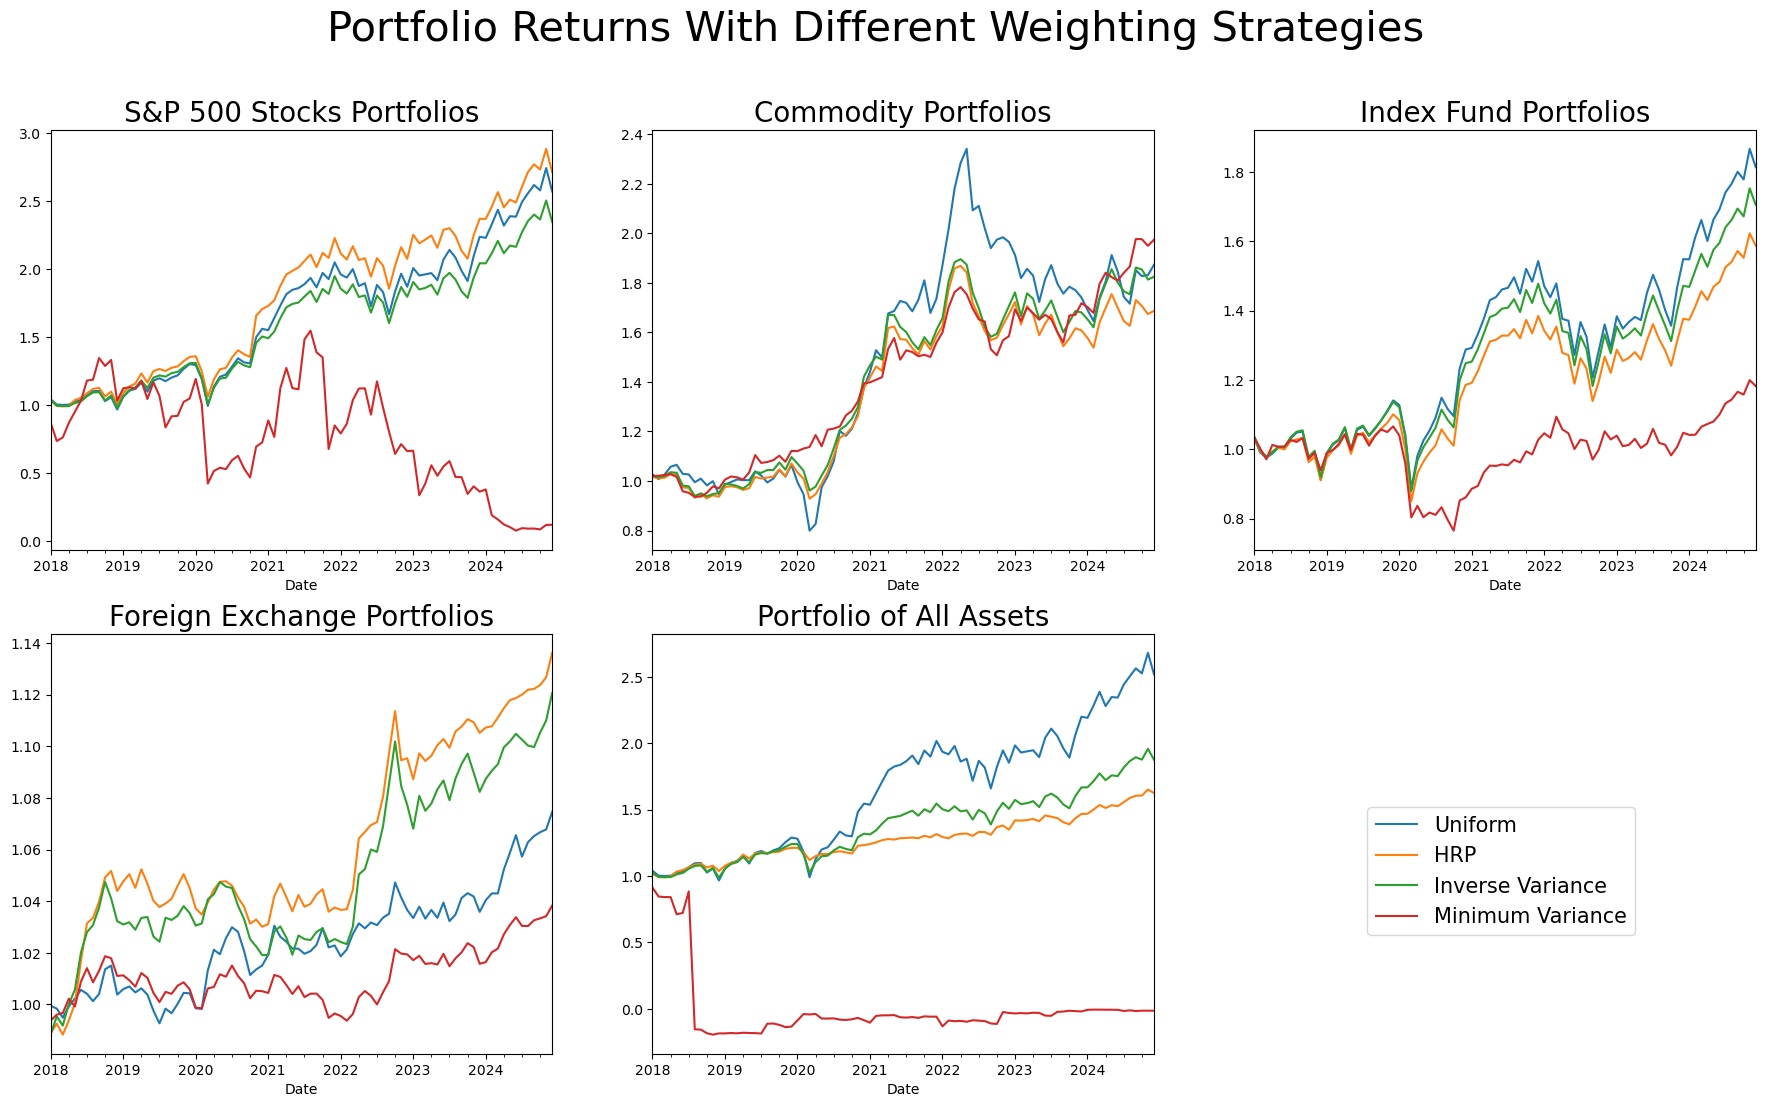

In [26]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 12))

data_arr = [rolling_returns_stock, rolling_returns_comm, rolling_returns_ind, rolling_returns_curr, rolling_returns_all]
titles_arr = ['S&P 500 Stocks Portfolios', 'Commodity Portfolios', 'Index Fund Portfolios', 'Foreign Exchange Portfolios', 'Portfolio of All Assets']

axes.flatten()[-1].remove()

for i, ax in enumerate(axes.flatten()[:-1]):
    data_arr[i].cumprod().plot(ax=ax)
    ax.set_title(titles_arr[i], fontsize=20)
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, legend_names, loc='lower right', bbox_to_anchor=(0.85,0.2), fontsize=15)
fig.suptitle('Portfolio Returns With Different Weighting Strategies', fontsize=30)

plt.savefig('portfolio-returns.png')

In [27]:
rolling_returns_all

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2018-01-31,1.03985,1.01642,1.0273,0.912598
2018-02-28,0.964001,0.976824,0.967101,0.926641
2018-03-31,0.997948,0.998144,0.997693,0.995258
2018-04-30,1.00201,1.00634,1.00126,0.999612
2018-05-31,1.02319,1.03652,1.01979,0.846438
...,...,...,...,...
2024-08-31,1.02513,1.02035,1.02697,0.706267
2024-09-30,1.02412,1.01067,1.01538,1.42996
2024-10-31,0.985294,1.00083,0.990477,0.828737


In [28]:
var_arr = [weight_var_stock, weight_var_comm, weight_var_curr, weight_var_ind, weight_var_all]
# Combine all variance dataframes into one
all_var_df = pd.concat([
    weight_var_stock.rename(columns={'Variance': 'Stocks'}),
    weight_var_comm.rename(columns={'Variance': 'Commodities'}),
    weight_var_curr.rename(columns={'Variance': 'Currencies'}), 
    weight_var_ind.rename(columns={'Variance': 'Indices'}),
    weight_var_all.rename(columns={'Variance': 'All Assets'})
], axis=1)

(all_var_df * 1000).round(3)

,Stocks,Commodities,Currencies,Indices,All Assets
HRP,0.002,8.795,9.874,2.025,0.114
RP,0.001,10.63,5.25,0.586,0.022
MV,29.677,98.555,5.876,1229.66,203.572


In [29]:
weight_var_comm

,Variance
HRP,0.00879453
RP,0.0106302
MV,0.0985554


In [30]:
# Get Sharpe ratios from stats dataframes
stats_arr = [equity_stats, comm_stats, curr_stats, ind_stats, all_stats]

risk_free_rate = 0.03

# Combine all Sharpe ratios into one dataframe
all_sharpe_df = pd.concat([
    pd.DataFrame((equity_stats.loc['Mean'] - risk_free_rate) / equity_stats.loc['Standard Deviation'], columns=['Stocks']),
    pd.DataFrame((comm_stats.loc['Mean'] - risk_free_rate) / comm_stats.loc['Standard Deviation'], columns=['Commodities']), 
    pd.DataFrame((curr_stats.loc['Mean'] - risk_free_rate) / curr_stats.loc['Standard Deviation'], columns=['Currencies']),
    pd.DataFrame((ind_stats.loc['Mean'] - risk_free_rate) / ind_stats.loc['Standard Deviation'], columns=['Indices']),
    pd.DataFrame((all_stats.loc['Mean'] - risk_free_rate) / all_stats.loc['Standard Deviation'], columns=['All Assets'])
], axis=1)

index = ['Uniform Weighting', 'HRP Portfolio', 'Inverse Variance Portfolio', 'Min-Variance Portfolio']

# Find max values in each column
max_vals = all_sharpe_df.max()

# Create a copy of rounded dataframe
df_rounded = all_sharpe_df.round(3)
df_rounded.index = index

# Bold max values
for col in df_rounded.columns:
    max_val = df_rounded[col].max()
    df_rounded[col] = df_rounded[col].apply(lambda x: f'\\textbf{{{x}}}' if x == max_val else str(x))

print(df_rounded.to_latex(escape=False))


\begin{tabular}{llllll}
\toprule
 & Stocks & Commodities & Currencies & Indices & All Assets \\
\midrule
Uniform Weighting & 2.293 & 1.497 & -3.991 & \textbf{1.473} & \textbf{2.292} \\
HRP Portfolio & \textbf{2.45} & 1.439 & \textbf{-1.89} & 1.117 & 2.161 \\
Inverse Variance Portfolio & 2.16 & 1.759 & -2.091 & 1.318 & 1.943 \\
Min-Variance Portfolio & -0.32 & \textbf{2.437} & -6.198 & 0.053 & -0.001 \\
\bottomrule
\end{tabular}



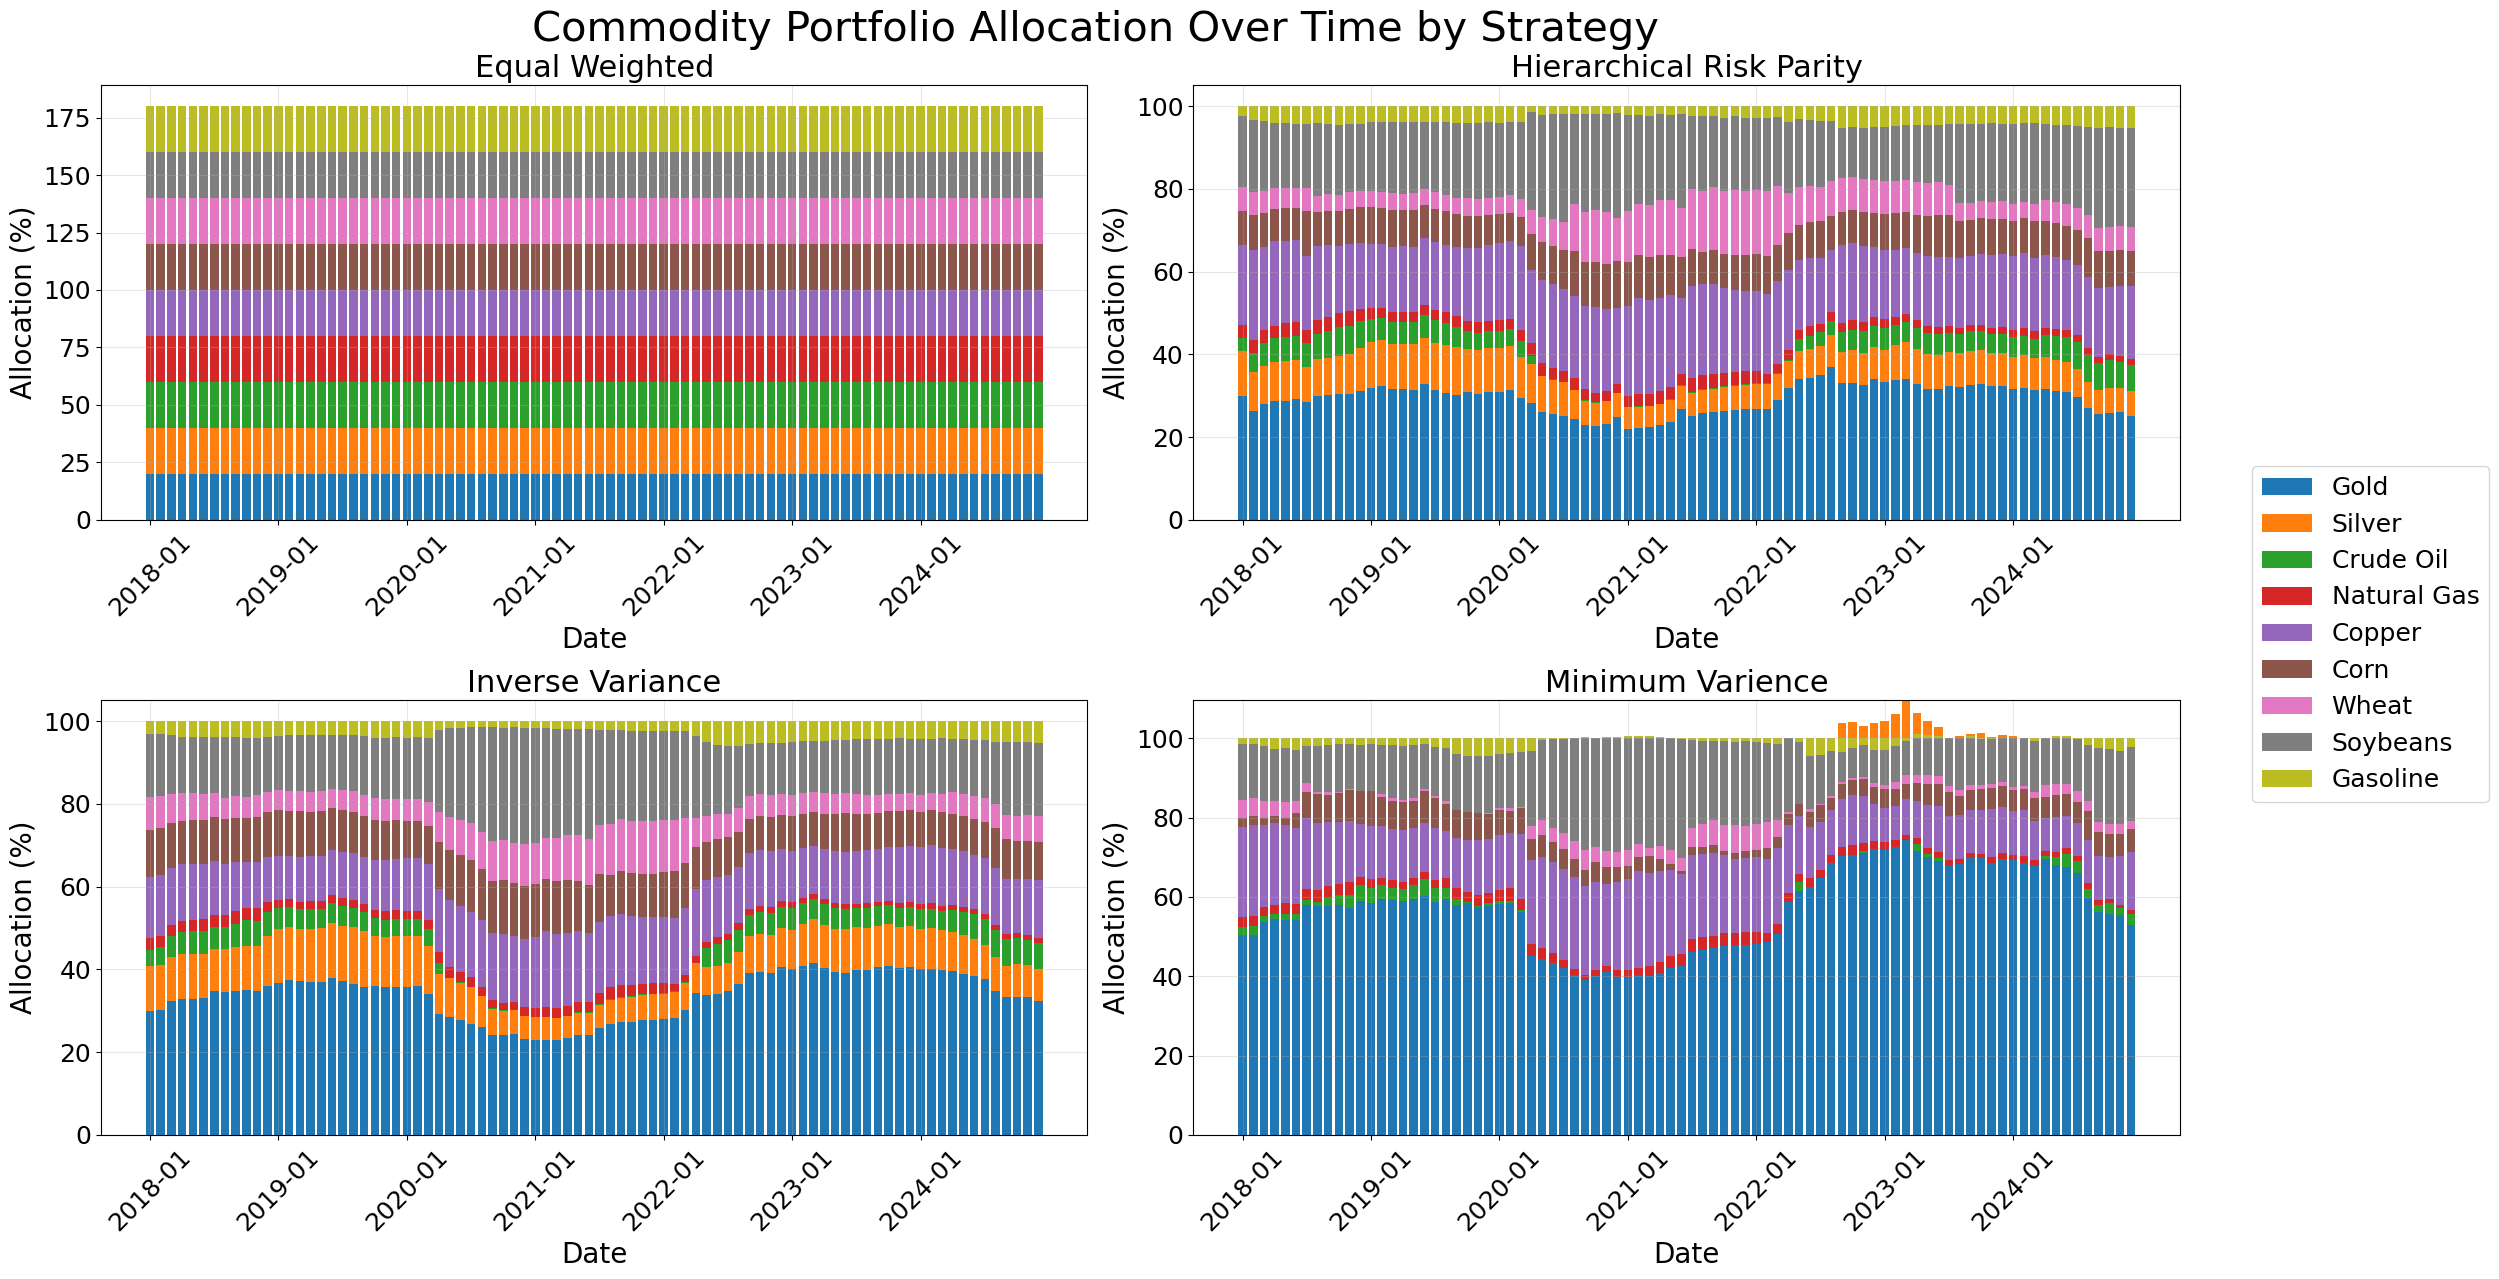

In [33]:
# Stacked Bar Plots for Commodity Weights Over Time

# Create figure
fig = plt.figure(figsize=(22, 13))
# fig, ax = plt.subplots(figsize=(22, 13))
fig.suptitle('Commodity Portfolio Allocation Over Time by Strategy', fontsize=30)

# Sample commodities
commodity_samples = comm_data.columns[1:]

# Get dates from commodity weights dataframe
dates = weights_dict_comm['hrp'].index

# Create stacked bars for each strategy
strategies = ['EQ', 'HRP', 'RP', 'MV']
x_positions = np.arange(len(dates))

# Store handles and labels for combined legend
handles, labels = None, None

for strategy in strategies:
    ax = plt.subplot(2, 2, strategies.index(strategy) + 1)
    bottom = np.zeros(len(dates))
    
    for commodity in commodity_samples:
        if strategy == 'EQ':
            weights = np.ones(len(dates)) * 0.2  # Equal weight of 20%
        elif strategy == 'HRP':
            weights = weights_dict_comm['hrp'][commodity].values
        elif strategy == 'RP':
            weights = weights_dict_comm['rp'][commodity].values
        else:  # MV
            weights = weights_dict_comm['mv'][commodity].values
            
        # Convert to percentages
        weights = weights * 100
        ax.bar(x_positions, weights, bottom=bottom, label=commodity)
        bottom += weights
        
        # Store handles and labels from first subplot for legend
        if strategy == 'EQ':
            handles, labels = ax.get_legend_handles_labels()
    
    if strategy == 'EQ':
        ax.set_title(f'Equal Weighted', fontsize=22)
    elif strategy == 'HRP':
        ax.set_title(f'Hierarchical Risk Parity', fontsize=22)
    elif strategy == 'RP':
        ax.set_title(f'Inverse Variance',fontsize=22)
    else:  # MV
        ax.set_title(f'Minimum Varience', fontsize=22)
    
    ax.set_ylabel('Allocation (%)', fontsize=20)
    ax.set_xlabel('Date', fontsize=20)
    
    # Format x-axis dates
    ax.set_xticks(x_positions[::12])  # Show every 12th date
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, alpha=0.3)

# Add single legend to figure
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=18)

plt.tight_layout()
plt.savefig('commodity-weights-over-time.png', bbox_inches='tight')


In [32]:
hrp_equities = HRP(file_path='sp500v2.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sp500v2.csv'

In [5]:
def plot_weights_comparison(weights_before, weights_after, title="Portfolio Weights Before vs. After Noise",n=10):
    """
    Plots a bar chart comparing HRP portfolio weights before and after adding noise.
    
    :param weights_before: Dictionary or Series of weights before adding noise.
    :param weights_after: Dictionary or Series of weights after adding noise.
    :param title: Title of the plot.
    """
    # Convert to Pandas Series for easy plotting
    weights_before = pd.Series(weights_before).sort_values(ascending=False)[:n]
    weights_after = pd.Series(weights_after).sort_values(ascending=False)[:n]

    # Align indices (tickers) to ensure proper comparison
    tickers = weights_before.index
    weights_after = weights_after.reindex(tickers, fill_value=0)

    x = np.arange(len(tickers))  # X-axis positions
    width = 0.4  # Bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars
    ax.bar(x - width/2, weights_before, width, label="Before Noise", color="tab:blue", alpha=0.7)
    ax.bar(x + width/2, weights_after, width, label="After Noise", color="tab:orange", alpha=0.7)

    # Labels and titles
    ax.set_xlabel("Tickers")
    ax.set_ylabel("Portfolio Weights")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(tickers, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()


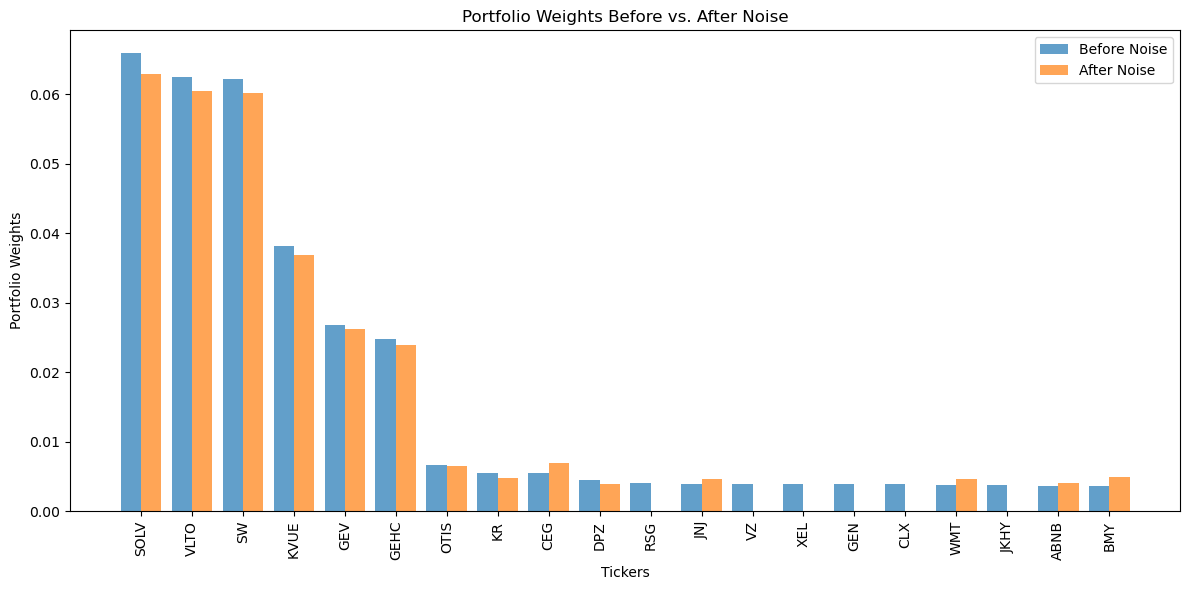

In [7]:
weights_before = hrp_equities.calculate_hrp_weights(corr_metric='simple')  # Without noise
weights_after = hrp_equities.calculate_hrp_weights(corr_metric='noise')    # With noise

plot_weights_comparison(weights_before, weights_after,n=20)